In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

from  IPython import display
from matplotlib import pyplot as plt
from scipy.ndimage.filters import gaussian_filter1d
import pandas as pd
import numpy as np

import tensorflow as tf

print("TensorFlow version: {}".format(tf.__version__)) 

TensorFlow version: 2.1.0


In [2]:
higgs_path = tf.keras.utils.get_file('HIGGSSmall.csv.gz', 'https://github.com/PacktWorkshops/The-Reinforcement-Learning-Workshop/blob/master/Chapter03/Dataset/HIGGSSmall.csv.gz?raw=true')

In [3]:
N_TEST = int(1e3)
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(N_TRAIN)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

N_FEATURES = 28

ds = tf.data.experimental.CsvDataset(higgs_path,[float(),]*(N_FEATURES+1), compression_type="GZIP")

def pack_row(*row):
    label = row[0]
    features = tf.stack(row[1:],1)
    return features, label

packed_ds = ds.batch(N_TRAIN).map(pack_row).unbatch()

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


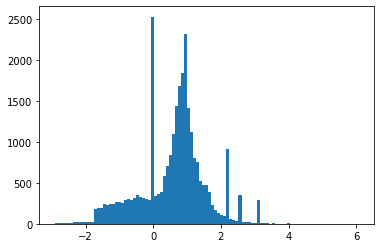

In [4]:
for features,label in packed_ds.batch(1000).take(1):
    print(features[0])
    plt.hist(features.numpy().flatten(), bins = 101)

In [5]:
validate_ds = packed_ds.take(N_VALIDATION).cache()
test_ds = packed_ds.skip(N_VALIDATION).take(N_TEST).cache()
train_ds = packed_ds.skip(N_VALIDATION+N_TEST).take(N_TRAIN).cache()

In [6]:
feature_names = ["lepton pT", "lepton eta", "lepton phi", "missing energy magnitude", "missing energy phi",
                 "jet 1 pt", "jet 1 eta", "jet 1 phi", "jet 1 b-tag", "jet 2 pt", "jet 2 eta", "jet 2 phi", 
                 "jet 2 b-tag", "jet 3 pt", "jet 3 eta", "jet 3 phi", "jet 3 b-tag", "jet 4 pt", "jet 4 eta", 
                 "jet 4 phi", "jet 4 b-tag", "m_jj", "m_jjj", "m_lv", "m_jlv", "m_bb", "m_wbb", "m_wwbb"]
label_name = ['Measure']
class_names = ['Signal', 'Background']

print("Features: {}".format(feature_names))
print("Label: {}".format(label_name))
print("Class names: {}".format(class_names))

Features: ['lepton pT', 'lepton eta', 'lepton phi', 'missing energy magnitude', 'missing energy phi', 'jet 1 pt', 'jet 1 eta', 'jet 1 phi', 'jet 1 b-tag', 'jet 2 pt', 'jet 2 eta', 'jet 2 phi', 'jet 2 b-tag', 'jet 3 pt', 'jet 3 eta', 'jet 3 phi', 'jet 3 b-tag', 'jet 4 pt', 'jet 4 eta', 'jet 4 phi', 'jet 4 b-tag', 'm_jj', 'm_jjj', 'm_lv', 'm_jlv', 'm_bb', 'm_wbb', 'm_wwbb']
Label: ['Measure']
Class names: ['Signal', 'Background']


In [7]:
features, labels = next(iter(train_ds))
print("Features =")
print(features.numpy())
print("Labels =")
print(labels.numpy())

Features =
[ 0.3923715   1.3781117   1.5673449   0.17123567  1.6574531   0.86394763
  0.88821083  1.4797885   2.1730762   1.2008675   0.9490923  -0.30092147
  2.2148721   1.277294    0.4025028   0.50748837  0.          0.50555664
 -0.55428815 -0.7055601   0.          0.94152564  0.9448251   0.9839765
  0.7801499   1.4989641   0.91668195  0.8027126 ]
Labels =
0.0


In [8]:
test_ds = test_ds.batch(BATCH_SIZE)
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

In [9]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

In [10]:
def compile_and_fit(model, name, max_epochs=3000):
    
    optimizer = tf.keras.optimizers.Adam(lr_schedule)
    
    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=[
                    tf.keras.losses.BinaryCrossentropy(
                        from_logits=True, name='binary_crossentropy'),
                    'accuracy'])

    model.summary()

    history = model.fit(train_ds,
                        steps_per_epoch = STEPS_PER_EPOCH,
                        epochs=max_epochs,
                        validation_data=validate_ds,
                        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200)],
                        verbose=2)
    return history

In [11]:
small_model = tf.keras.Sequential([tf.keras.layers.Dense(16, activation='elu', input_shape=(N_FEATURES,)),
                                  tf.keras.layers.Dense(1)])

size_histories = {}

size_histories['small'] = compile_and_fit(small_model, 'sizes/small')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                464       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________
Train for 20 steps
Epoch 1/3000
20/20 - 2s - loss: 0.9614 - binary_crossentropy: 0.9614 - accuracy: 0.4751 - val_loss: 0.8033 - val_binary_crossentropy: 0.8033 - val_accuracy: 0.4680
Epoch 2/3000
20/20 - 0s - loss: 0.7789 - binary_crossentropy: 0.7789 - accuracy: 0.4738 - val_loss: 0.7379 - val_binary_crossentropy: 0.7379 - val_accuracy: 0.4760
Epoch 3/3000
20/20 - 0s - loss: 0.7492 - binary_crossentropy: 0.7492 - accuracy: 0.4725 - val_loss: 0.7256 - val_binary_crossentropy: 0.7256 - val_accuracy: 0.4850
Epoch 4/3

Epoch 47/3000
20/20 - 0s - loss: 0.6446 - binary_crossentropy: 0.6446 - accuracy: 0.5614 - val_loss: 0.6464 - val_binary_crossentropy: 0.6464 - val_accuracy: 0.5450
Epoch 48/3000
20/20 - 0s - loss: 0.6442 - binary_crossentropy: 0.6442 - accuracy: 0.5623 - val_loss: 0.6449 - val_binary_crossentropy: 0.6449 - val_accuracy: 0.5550
Epoch 49/3000
20/20 - 0s - loss: 0.6441 - binary_crossentropy: 0.6441 - accuracy: 0.5662 - val_loss: 0.6440 - val_binary_crossentropy: 0.6440 - val_accuracy: 0.5560
Epoch 50/3000
20/20 - 0s - loss: 0.6435 - binary_crossentropy: 0.6435 - accuracy: 0.5646 - val_loss: 0.6436 - val_binary_crossentropy: 0.6436 - val_accuracy: 0.5630
Epoch 51/3000
20/20 - 0s - loss: 0.6433 - binary_crossentropy: 0.6433 - accuracy: 0.5679 - val_loss: 0.6439 - val_binary_crossentropy: 0.6439 - val_accuracy: 0.5550
Epoch 52/3000
20/20 - 0s - loss: 0.6429 - binary_crossentropy: 0.6429 - accuracy: 0.5706 - val_loss: 0.6439 - val_binary_crossentropy: 0.6439 - val_accuracy: 0.5560
Epoch 53/3

Epoch 97/3000
20/20 - 0s - loss: 0.6336 - binary_crossentropy: 0.6336 - accuracy: 0.5815 - val_loss: 0.6309 - val_binary_crossentropy: 0.6309 - val_accuracy: 0.5830
Epoch 98/3000
20/20 - 0s - loss: 0.6336 - binary_crossentropy: 0.6336 - accuracy: 0.5854 - val_loss: 0.6309 - val_binary_crossentropy: 0.6309 - val_accuracy: 0.5860
Epoch 99/3000
20/20 - 0s - loss: 0.6339 - binary_crossentropy: 0.6339 - accuracy: 0.5813 - val_loss: 0.6306 - val_binary_crossentropy: 0.6306 - val_accuracy: 0.5960
Epoch 100/3000
20/20 - 0s - loss: 0.6333 - binary_crossentropy: 0.6333 - accuracy: 0.5833 - val_loss: 0.6299 - val_binary_crossentropy: 0.6299 - val_accuracy: 0.5890
Epoch 101/3000
20/20 - 0s - loss: 0.6331 - binary_crossentropy: 0.6331 - accuracy: 0.5835 - val_loss: 0.6302 - val_binary_crossentropy: 0.6302 - val_accuracy: 0.5960
Epoch 102/3000
20/20 - 0s - loss: 0.6327 - binary_crossentropy: 0.6327 - accuracy: 0.5876 - val_loss: 0.6305 - val_binary_crossentropy: 0.6305 - val_accuracy: 0.5820
Epoch 1

Epoch 147/3000
20/20 - 0s - loss: 0.6273 - binary_crossentropy: 0.6273 - accuracy: 0.5983 - val_loss: 0.6215 - val_binary_crossentropy: 0.6215 - val_accuracy: 0.5980
Epoch 148/3000
20/20 - 0s - loss: 0.6263 - binary_crossentropy: 0.6263 - accuracy: 0.6011 - val_loss: 0.6240 - val_binary_crossentropy: 0.6240 - val_accuracy: 0.5690
Epoch 149/3000
20/20 - 0s - loss: 0.6263 - binary_crossentropy: 0.6263 - accuracy: 0.5960 - val_loss: 0.6220 - val_binary_crossentropy: 0.6220 - val_accuracy: 0.5980
Epoch 150/3000
20/20 - 0s - loss: 0.6261 - binary_crossentropy: 0.6261 - accuracy: 0.5969 - val_loss: 0.6217 - val_binary_crossentropy: 0.6217 - val_accuracy: 0.5970
Epoch 151/3000
20/20 - 0s - loss: 0.6261 - binary_crossentropy: 0.6261 - accuracy: 0.5995 - val_loss: 0.6219 - val_binary_crossentropy: 0.6219 - val_accuracy: 0.5960
Epoch 152/3000
20/20 - 0s - loss: 0.6260 - binary_crossentropy: 0.6260 - accuracy: 0.5984 - val_loss: 0.6213 - val_binary_crossentropy: 0.6213 - val_accuracy: 0.5980
Epoc

Epoch 197/3000
20/20 - 0s - loss: 0.6215 - binary_crossentropy: 0.6215 - accuracy: 0.6071 - val_loss: 0.6144 - val_binary_crossentropy: 0.6144 - val_accuracy: 0.6090
Epoch 198/3000
20/20 - 0s - loss: 0.6209 - binary_crossentropy: 0.6209 - accuracy: 0.6063 - val_loss: 0.6147 - val_binary_crossentropy: 0.6147 - val_accuracy: 0.6090
Epoch 199/3000
20/20 - 0s - loss: 0.6209 - binary_crossentropy: 0.6209 - accuracy: 0.6081 - val_loss: 0.6151 - val_binary_crossentropy: 0.6151 - val_accuracy: 0.6090
Epoch 200/3000
20/20 - 0s - loss: 0.6208 - binary_crossentropy: 0.6208 - accuracy: 0.6082 - val_loss: 0.6149 - val_binary_crossentropy: 0.6149 - val_accuracy: 0.6090
Epoch 201/3000
20/20 - 0s - loss: 0.6212 - binary_crossentropy: 0.6212 - accuracy: 0.6081 - val_loss: 0.6148 - val_binary_crossentropy: 0.6148 - val_accuracy: 0.6120
Epoch 202/3000
20/20 - 0s - loss: 0.6209 - binary_crossentropy: 0.6209 - accuracy: 0.6063 - val_loss: 0.6134 - val_binary_crossentropy: 0.6134 - val_accuracy: 0.6200
Epoc

Epoch 247/3000
20/20 - 0s - loss: 0.6169 - binary_crossentropy: 0.6169 - accuracy: 0.6123 - val_loss: 0.6083 - val_binary_crossentropy: 0.6083 - val_accuracy: 0.6300
Epoch 248/3000
20/20 - 0s - loss: 0.6169 - binary_crossentropy: 0.6169 - accuracy: 0.6194 - val_loss: 0.6094 - val_binary_crossentropy: 0.6094 - val_accuracy: 0.6290
Epoch 249/3000
20/20 - 0s - loss: 0.6165 - binary_crossentropy: 0.6165 - accuracy: 0.6146 - val_loss: 0.6097 - val_binary_crossentropy: 0.6097 - val_accuracy: 0.6290
Epoch 250/3000
20/20 - 0s - loss: 0.6162 - binary_crossentropy: 0.6162 - accuracy: 0.6181 - val_loss: 0.6092 - val_binary_crossentropy: 0.6092 - val_accuracy: 0.6210
Epoch 251/3000
20/20 - 0s - loss: 0.6161 - binary_crossentropy: 0.6161 - accuracy: 0.6192 - val_loss: 0.6093 - val_binary_crossentropy: 0.6093 - val_accuracy: 0.6250
Epoch 252/3000
20/20 - 0s - loss: 0.6161 - binary_crossentropy: 0.6161 - accuracy: 0.6158 - val_loss: 0.6095 - val_binary_crossentropy: 0.6095 - val_accuracy: 0.6160
Epoc

Epoch 297/3000
20/20 - 0s - loss: 0.6117 - binary_crossentropy: 0.6117 - accuracy: 0.6267 - val_loss: 0.6054 - val_binary_crossentropy: 0.6054 - val_accuracy: 0.6300
Epoch 298/3000
20/20 - 0s - loss: 0.6116 - binary_crossentropy: 0.6116 - accuracy: 0.6222 - val_loss: 0.6046 - val_binary_crossentropy: 0.6046 - val_accuracy: 0.6360
Epoch 299/3000
20/20 - 0s - loss: 0.6116 - binary_crossentropy: 0.6116 - accuracy: 0.6237 - val_loss: 0.6041 - val_binary_crossentropy: 0.6041 - val_accuracy: 0.6350
Epoch 300/3000
20/20 - 0s - loss: 0.6113 - binary_crossentropy: 0.6113 - accuracy: 0.6272 - val_loss: 0.6060 - val_binary_crossentropy: 0.6060 - val_accuracy: 0.6210
Epoch 301/3000
20/20 - 0s - loss: 0.6115 - binary_crossentropy: 0.6115 - accuracy: 0.6254 - val_loss: 0.6060 - val_binary_crossentropy: 0.6060 - val_accuracy: 0.6180
Epoch 302/3000
20/20 - 0s - loss: 0.6111 - binary_crossentropy: 0.6111 - accuracy: 0.6220 - val_loss: 0.6038 - val_binary_crossentropy: 0.6038 - val_accuracy: 0.6360
Epoc

Epoch 347/3000
20/20 - 0s - loss: 0.6071 - binary_crossentropy: 0.6071 - accuracy: 0.6349 - val_loss: 0.5996 - val_binary_crossentropy: 0.5996 - val_accuracy: 0.6360
Epoch 348/3000
20/20 - 0s - loss: 0.6065 - binary_crossentropy: 0.6065 - accuracy: 0.6363 - val_loss: 0.5997 - val_binary_crossentropy: 0.5997 - val_accuracy: 0.6360
Epoch 349/3000
20/20 - 0s - loss: 0.6065 - binary_crossentropy: 0.6065 - accuracy: 0.6373 - val_loss: 0.6014 - val_binary_crossentropy: 0.6014 - val_accuracy: 0.6230
Epoch 350/3000
20/20 - 0s - loss: 0.6068 - binary_crossentropy: 0.6068 - accuracy: 0.6329 - val_loss: 0.6002 - val_binary_crossentropy: 0.6002 - val_accuracy: 0.6330
Epoch 351/3000
20/20 - 0s - loss: 0.6065 - binary_crossentropy: 0.6065 - accuracy: 0.6328 - val_loss: 0.6004 - val_binary_crossentropy: 0.6004 - val_accuracy: 0.6350
Epoch 352/3000
20/20 - 0s - loss: 0.6061 - binary_crossentropy: 0.6061 - accuracy: 0.6331 - val_loss: 0.5990 - val_binary_crossentropy: 0.5990 - val_accuracy: 0.6650
Epoc

Epoch 397/3000
20/20 - 0s - loss: 0.6021 - binary_crossentropy: 0.6021 - accuracy: 0.6419 - val_loss: 0.5948 - val_binary_crossentropy: 0.5948 - val_accuracy: 0.6500
Epoch 398/3000
20/20 - 0s - loss: 0.6019 - binary_crossentropy: 0.6019 - accuracy: 0.6412 - val_loss: 0.5953 - val_binary_crossentropy: 0.5953 - val_accuracy: 0.6430
Epoch 399/3000
20/20 - 0s - loss: 0.6020 - binary_crossentropy: 0.6020 - accuracy: 0.6445 - val_loss: 0.5962 - val_binary_crossentropy: 0.5962 - val_accuracy: 0.6350
Epoch 400/3000
20/20 - 0s - loss: 0.6016 - binary_crossentropy: 0.6016 - accuracy: 0.6427 - val_loss: 0.5940 - val_binary_crossentropy: 0.5940 - val_accuracy: 0.6490
Epoch 401/3000
20/20 - 0s - loss: 0.6018 - binary_crossentropy: 0.6018 - accuracy: 0.6437 - val_loss: 0.5951 - val_binary_crossentropy: 0.5951 - val_accuracy: 0.6480
Epoch 402/3000
20/20 - 0s - loss: 0.6018 - binary_crossentropy: 0.6018 - accuracy: 0.6368 - val_loss: 0.5941 - val_binary_crossentropy: 0.5941 - val_accuracy: 0.6520
Epoc

Epoch 447/3000
20/20 - 0s - loss: 0.5984 - binary_crossentropy: 0.5984 - accuracy: 0.6493 - val_loss: 0.5917 - val_binary_crossentropy: 0.5917 - val_accuracy: 0.6500
Epoch 448/3000
20/20 - 0s - loss: 0.5985 - binary_crossentropy: 0.5985 - accuracy: 0.6506 - val_loss: 0.5918 - val_binary_crossentropy: 0.5918 - val_accuracy: 0.6500
Epoch 449/3000
20/20 - 0s - loss: 0.5984 - binary_crossentropy: 0.5984 - accuracy: 0.6481 - val_loss: 0.5911 - val_binary_crossentropy: 0.5911 - val_accuracy: 0.6470
Epoch 450/3000
20/20 - 0s - loss: 0.5978 - binary_crossentropy: 0.5978 - accuracy: 0.6505 - val_loss: 0.5910 - val_binary_crossentropy: 0.5910 - val_accuracy: 0.6530
Epoch 451/3000
20/20 - 0s - loss: 0.5981 - binary_crossentropy: 0.5981 - accuracy: 0.6508 - val_loss: 0.5908 - val_binary_crossentropy: 0.5908 - val_accuracy: 0.6600
Epoch 452/3000
20/20 - 0s - loss: 0.5978 - binary_crossentropy: 0.5978 - accuracy: 0.6486 - val_loss: 0.5914 - val_binary_crossentropy: 0.5914 - val_accuracy: 0.6500
Epoc

Epoch 497/3000
20/20 - 0s - loss: 0.5957 - binary_crossentropy: 0.5957 - accuracy: 0.6583 - val_loss: 0.5879 - val_binary_crossentropy: 0.5879 - val_accuracy: 0.6510
Epoch 498/3000
20/20 - 0s - loss: 0.5950 - binary_crossentropy: 0.5950 - accuracy: 0.6515 - val_loss: 0.5883 - val_binary_crossentropy: 0.5883 - val_accuracy: 0.6540
Epoch 499/3000
20/20 - 0s - loss: 0.5952 - binary_crossentropy: 0.5952 - accuracy: 0.6559 - val_loss: 0.5914 - val_binary_crossentropy: 0.5914 - val_accuracy: 0.6410
Epoch 500/3000
20/20 - 0s - loss: 0.5951 - binary_crossentropy: 0.5951 - accuracy: 0.6581 - val_loss: 0.5886 - val_binary_crossentropy: 0.5886 - val_accuracy: 0.6530
Epoch 501/3000
20/20 - 0s - loss: 0.5949 - binary_crossentropy: 0.5949 - accuracy: 0.6542 - val_loss: 0.5888 - val_binary_crossentropy: 0.5888 - val_accuracy: 0.6520
Epoch 502/3000
20/20 - 0s - loss: 0.5952 - binary_crossentropy: 0.5952 - accuracy: 0.6525 - val_loss: 0.5906 - val_binary_crossentropy: 0.5906 - val_accuracy: 0.6430
Epoc

Epoch 547/3000
20/20 - 0s - loss: 0.5924 - binary_crossentropy: 0.5924 - accuracy: 0.6565 - val_loss: 0.5864 - val_binary_crossentropy: 0.5864 - val_accuracy: 0.6520
Epoch 548/3000
20/20 - 0s - loss: 0.5930 - binary_crossentropy: 0.5930 - accuracy: 0.6599 - val_loss: 0.5862 - val_binary_crossentropy: 0.5862 - val_accuracy: 0.6630
Epoch 549/3000
20/20 - 0s - loss: 0.5926 - binary_crossentropy: 0.5926 - accuracy: 0.6572 - val_loss: 0.5873 - val_binary_crossentropy: 0.5873 - val_accuracy: 0.6530
Epoch 550/3000
20/20 - 0s - loss: 0.5926 - binary_crossentropy: 0.5926 - accuracy: 0.6623 - val_loss: 0.5875 - val_binary_crossentropy: 0.5875 - val_accuracy: 0.6520
Epoch 551/3000
20/20 - 0s - loss: 0.5928 - binary_crossentropy: 0.5928 - accuracy: 0.6600 - val_loss: 0.5868 - val_binary_crossentropy: 0.5868 - val_accuracy: 0.6520
Epoch 552/3000
20/20 - 0s - loss: 0.5924 - binary_crossentropy: 0.5924 - accuracy: 0.6600 - val_loss: 0.5867 - val_binary_crossentropy: 0.5867 - val_accuracy: 0.6530
Epoc

Epoch 597/3000
20/20 - 0s - loss: 0.5905 - binary_crossentropy: 0.5905 - accuracy: 0.6628 - val_loss: 0.5848 - val_binary_crossentropy: 0.5848 - val_accuracy: 0.6610
Epoch 598/3000
20/20 - 0s - loss: 0.5904 - binary_crossentropy: 0.5904 - accuracy: 0.6646 - val_loss: 0.5876 - val_binary_crossentropy: 0.5876 - val_accuracy: 0.6410
Epoch 599/3000
20/20 - 0s - loss: 0.5903 - binary_crossentropy: 0.5903 - accuracy: 0.6610 - val_loss: 0.5847 - val_binary_crossentropy: 0.5847 - val_accuracy: 0.6620
Epoch 600/3000
20/20 - 0s - loss: 0.5905 - binary_crossentropy: 0.5905 - accuracy: 0.6628 - val_loss: 0.5846 - val_binary_crossentropy: 0.5846 - val_accuracy: 0.6640
Epoch 601/3000
20/20 - 0s - loss: 0.5903 - binary_crossentropy: 0.5903 - accuracy: 0.6632 - val_loss: 0.5848 - val_binary_crossentropy: 0.5848 - val_accuracy: 0.6540
Epoch 602/3000
20/20 - 0s - loss: 0.5903 - binary_crossentropy: 0.5903 - accuracy: 0.6637 - val_loss: 0.5847 - val_binary_crossentropy: 0.5847 - val_accuracy: 0.6580
Epoc

Epoch 647/3000
20/20 - 0s - loss: 0.5882 - binary_crossentropy: 0.5882 - accuracy: 0.6634 - val_loss: 0.5839 - val_binary_crossentropy: 0.5839 - val_accuracy: 0.6560
Epoch 648/3000
20/20 - 0s - loss: 0.5882 - binary_crossentropy: 0.5882 - accuracy: 0.6658 - val_loss: 0.5836 - val_binary_crossentropy: 0.5836 - val_accuracy: 0.6570
Epoch 649/3000
20/20 - 0s - loss: 0.5882 - binary_crossentropy: 0.5882 - accuracy: 0.6670 - val_loss: 0.5828 - val_binary_crossentropy: 0.5828 - val_accuracy: 0.6670
Epoch 650/3000
20/20 - 0s - loss: 0.5883 - binary_crossentropy: 0.5883 - accuracy: 0.6654 - val_loss: 0.5831 - val_binary_crossentropy: 0.5831 - val_accuracy: 0.6600
Epoch 651/3000
20/20 - 0s - loss: 0.5881 - binary_crossentropy: 0.5881 - accuracy: 0.6659 - val_loss: 0.5833 - val_binary_crossentropy: 0.5833 - val_accuracy: 0.6610
Epoch 652/3000
20/20 - 0s - loss: 0.5881 - binary_crossentropy: 0.5881 - accuracy: 0.6647 - val_loss: 0.5824 - val_binary_crossentropy: 0.5824 - val_accuracy: 0.6660
Epoc

Epoch 697/3000
20/20 - 0s - loss: 0.5869 - binary_crossentropy: 0.5869 - accuracy: 0.6679 - val_loss: 0.5829 - val_binary_crossentropy: 0.5829 - val_accuracy: 0.6570
Epoch 698/3000
20/20 - 0s - loss: 0.5864 - binary_crossentropy: 0.5864 - accuracy: 0.6665 - val_loss: 0.5814 - val_binary_crossentropy: 0.5814 - val_accuracy: 0.6670
Epoch 699/3000
20/20 - 0s - loss: 0.5863 - binary_crossentropy: 0.5863 - accuracy: 0.6717 - val_loss: 0.5845 - val_binary_crossentropy: 0.5845 - val_accuracy: 0.6460
Epoch 700/3000
20/20 - 0s - loss: 0.5869 - binary_crossentropy: 0.5869 - accuracy: 0.6676 - val_loss: 0.5840 - val_binary_crossentropy: 0.5840 - val_accuracy: 0.6500
Epoch 701/3000
20/20 - 0s - loss: 0.5866 - binary_crossentropy: 0.5866 - accuracy: 0.6624 - val_loss: 0.5819 - val_binary_crossentropy: 0.5819 - val_accuracy: 0.6710
Epoch 702/3000
20/20 - 0s - loss: 0.5864 - binary_crossentropy: 0.5864 - accuracy: 0.6657 - val_loss: 0.5829 - val_binary_crossentropy: 0.5829 - val_accuracy: 0.6490
Epoc

Epoch 747/3000
20/20 - 0s - loss: 0.5850 - binary_crossentropy: 0.5850 - accuracy: 0.6667 - val_loss: 0.5806 - val_binary_crossentropy: 0.5806 - val_accuracy: 0.6640
Epoch 748/3000
20/20 - 0s - loss: 0.5848 - binary_crossentropy: 0.5848 - accuracy: 0.6684 - val_loss: 0.5837 - val_binary_crossentropy: 0.5837 - val_accuracy: 0.6450
Epoch 749/3000
20/20 - 0s - loss: 0.5850 - binary_crossentropy: 0.5850 - accuracy: 0.6671 - val_loss: 0.5816 - val_binary_crossentropy: 0.5816 - val_accuracy: 0.6620
Epoch 750/3000
20/20 - 0s - loss: 0.5847 - binary_crossentropy: 0.5847 - accuracy: 0.6691 - val_loss: 0.5803 - val_binary_crossentropy: 0.5803 - val_accuracy: 0.6690
Epoch 751/3000
20/20 - 0s - loss: 0.5846 - binary_crossentropy: 0.5846 - accuracy: 0.6706 - val_loss: 0.5818 - val_binary_crossentropy: 0.5818 - val_accuracy: 0.6620
Epoch 752/3000
20/20 - 0s - loss: 0.5846 - binary_crossentropy: 0.5846 - accuracy: 0.6693 - val_loss: 0.5820 - val_binary_crossentropy: 0.5820 - val_accuracy: 0.6520
Epoc

Epoch 797/3000
20/20 - 0s - loss: 0.5835 - binary_crossentropy: 0.5835 - accuracy: 0.6648 - val_loss: 0.5795 - val_binary_crossentropy: 0.5795 - val_accuracy: 0.6790
Epoch 798/3000
20/20 - 0s - loss: 0.5834 - binary_crossentropy: 0.5834 - accuracy: 0.6704 - val_loss: 0.5805 - val_binary_crossentropy: 0.5805 - val_accuracy: 0.6640
Epoch 799/3000
20/20 - 0s - loss: 0.5833 - binary_crossentropy: 0.5833 - accuracy: 0.6695 - val_loss: 0.5801 - val_binary_crossentropy: 0.5801 - val_accuracy: 0.6690
Epoch 800/3000
20/20 - 0s - loss: 0.5832 - binary_crossentropy: 0.5832 - accuracy: 0.6717 - val_loss: 0.5813 - val_binary_crossentropy: 0.5813 - val_accuracy: 0.6570
Epoch 801/3000
20/20 - 0s - loss: 0.5836 - binary_crossentropy: 0.5836 - accuracy: 0.6688 - val_loss: 0.5801 - val_binary_crossentropy: 0.5801 - val_accuracy: 0.6620
Epoch 802/3000
20/20 - 0s - loss: 0.5836 - binary_crossentropy: 0.5836 - accuracy: 0.6674 - val_loss: 0.5793 - val_binary_crossentropy: 0.5793 - val_accuracy: 0.6710
Epoc

Epoch 847/3000
20/20 - 0s - loss: 0.5825 - binary_crossentropy: 0.5825 - accuracy: 0.6714 - val_loss: 0.5795 - val_binary_crossentropy: 0.5795 - val_accuracy: 0.6750
Epoch 848/3000
20/20 - 0s - loss: 0.5821 - binary_crossentropy: 0.5821 - accuracy: 0.6671 - val_loss: 0.5789 - val_binary_crossentropy: 0.5789 - val_accuracy: 0.6800
Epoch 849/3000
20/20 - 0s - loss: 0.5822 - binary_crossentropy: 0.5822 - accuracy: 0.6715 - val_loss: 0.5794 - val_binary_crossentropy: 0.5794 - val_accuracy: 0.6750
Epoch 850/3000
20/20 - 0s - loss: 0.5820 - binary_crossentropy: 0.5820 - accuracy: 0.6720 - val_loss: 0.5793 - val_binary_crossentropy: 0.5793 - val_accuracy: 0.6750
Epoch 851/3000
20/20 - 0s - loss: 0.5822 - binary_crossentropy: 0.5822 - accuracy: 0.6669 - val_loss: 0.5787 - val_binary_crossentropy: 0.5787 - val_accuracy: 0.6840
Epoch 852/3000
20/20 - 0s - loss: 0.5820 - binary_crossentropy: 0.5820 - accuracy: 0.6748 - val_loss: 0.5829 - val_binary_crossentropy: 0.5829 - val_accuracy: 0.6420
Epoc

Epoch 897/3000
20/20 - 0s - loss: 0.5811 - binary_crossentropy: 0.5811 - accuracy: 0.6737 - val_loss: 0.5808 - val_binary_crossentropy: 0.5808 - val_accuracy: 0.6590
Epoch 898/3000
20/20 - 0s - loss: 0.5815 - binary_crossentropy: 0.5815 - accuracy: 0.6719 - val_loss: 0.5806 - val_binary_crossentropy: 0.5806 - val_accuracy: 0.6560
Epoch 899/3000
20/20 - 0s - loss: 0.5815 - binary_crossentropy: 0.5815 - accuracy: 0.6716 - val_loss: 0.5796 - val_binary_crossentropy: 0.5796 - val_accuracy: 0.6700
Epoch 900/3000
20/20 - 0s - loss: 0.5810 - binary_crossentropy: 0.5810 - accuracy: 0.6676 - val_loss: 0.5783 - val_binary_crossentropy: 0.5783 - val_accuracy: 0.6800
Epoch 901/3000
20/20 - 0s - loss: 0.5809 - binary_crossentropy: 0.5809 - accuracy: 0.6744 - val_loss: 0.5795 - val_binary_crossentropy: 0.5795 - val_accuracy: 0.6690
Epoch 902/3000
20/20 - 0s - loss: 0.5811 - binary_crossentropy: 0.5811 - accuracy: 0.6711 - val_loss: 0.5788 - val_binary_crossentropy: 0.5788 - val_accuracy: 0.6720
Epoc

Epoch 947/3000
20/20 - 0s - loss: 0.5803 - binary_crossentropy: 0.5803 - accuracy: 0.6727 - val_loss: 0.5787 - val_binary_crossentropy: 0.5787 - val_accuracy: 0.6630
Epoch 948/3000
20/20 - 0s - loss: 0.5799 - binary_crossentropy: 0.5799 - accuracy: 0.6712 - val_loss: 0.5777 - val_binary_crossentropy: 0.5777 - val_accuracy: 0.6720
Epoch 949/3000
20/20 - 0s - loss: 0.5799 - binary_crossentropy: 0.5799 - accuracy: 0.6728 - val_loss: 0.5793 - val_binary_crossentropy: 0.5793 - val_accuracy: 0.6660
Epoch 950/3000
20/20 - 0s - loss: 0.5801 - binary_crossentropy: 0.5801 - accuracy: 0.6709 - val_loss: 0.5792 - val_binary_crossentropy: 0.5792 - val_accuracy: 0.6650
Epoch 951/3000
20/20 - 0s - loss: 0.5799 - binary_crossentropy: 0.5799 - accuracy: 0.6720 - val_loss: 0.5781 - val_binary_crossentropy: 0.5781 - val_accuracy: 0.6670
Epoch 952/3000
20/20 - 0s - loss: 0.5798 - binary_crossentropy: 0.5798 - accuracy: 0.6706 - val_loss: 0.5779 - val_binary_crossentropy: 0.5779 - val_accuracy: 0.6720
Epoc

Epoch 997/3000
20/20 - 0s - loss: 0.5789 - binary_crossentropy: 0.5789 - accuracy: 0.6738 - val_loss: 0.5778 - val_binary_crossentropy: 0.5778 - val_accuracy: 0.6700
Epoch 998/3000
20/20 - 0s - loss: 0.5790 - binary_crossentropy: 0.5790 - accuracy: 0.6746 - val_loss: 0.5795 - val_binary_crossentropy: 0.5795 - val_accuracy: 0.6650
Epoch 999/3000
20/20 - 0s - loss: 0.5790 - binary_crossentropy: 0.5790 - accuracy: 0.6711 - val_loss: 0.5772 - val_binary_crossentropy: 0.5772 - val_accuracy: 0.6820
Epoch 1000/3000
20/20 - 0s - loss: 0.5789 - binary_crossentropy: 0.5789 - accuracy: 0.6727 - val_loss: 0.5773 - val_binary_crossentropy: 0.5773 - val_accuracy: 0.6720
Epoch 1001/3000
20/20 - 0s - loss: 0.5791 - binary_crossentropy: 0.5791 - accuracy: 0.6712 - val_loss: 0.5772 - val_binary_crossentropy: 0.5772 - val_accuracy: 0.6840
Epoch 1002/3000
20/20 - 0s - loss: 0.5793 - binary_crossentropy: 0.5793 - accuracy: 0.6763 - val_loss: 0.5801 - val_binary_crossentropy: 0.5801 - val_accuracy: 0.6590
E

20/20 - 0s - loss: 0.5781 - binary_crossentropy: 0.5781 - accuracy: 0.6741 - val_loss: 0.5765 - val_binary_crossentropy: 0.5765 - val_accuracy: 0.6770
Epoch 1047/3000
20/20 - 0s - loss: 0.5782 - binary_crossentropy: 0.5782 - accuracy: 0.6741 - val_loss: 0.5779 - val_binary_crossentropy: 0.5779 - val_accuracy: 0.6770
Epoch 1048/3000
20/20 - 0s - loss: 0.5782 - binary_crossentropy: 0.5782 - accuracy: 0.6767 - val_loss: 0.5788 - val_binary_crossentropy: 0.5788 - val_accuracy: 0.6690
Epoch 1049/3000
20/20 - 0s - loss: 0.5781 - binary_crossentropy: 0.5781 - accuracy: 0.6727 - val_loss: 0.5778 - val_binary_crossentropy: 0.5778 - val_accuracy: 0.6750
Epoch 1050/3000
20/20 - 0s - loss: 0.5784 - binary_crossentropy: 0.5784 - accuracy: 0.6724 - val_loss: 0.5784 - val_binary_crossentropy: 0.5784 - val_accuracy: 0.6740
Epoch 1051/3000
20/20 - 0s - loss: 0.5787 - binary_crossentropy: 0.5787 - accuracy: 0.6747 - val_loss: 0.5814 - val_binary_crossentropy: 0.5814 - val_accuracy: 0.6480
Epoch 1052/300

Epoch 1096/3000
20/20 - 0s - loss: 0.5773 - binary_crossentropy: 0.5773 - accuracy: 0.6788 - val_loss: 0.5776 - val_binary_crossentropy: 0.5776 - val_accuracy: 0.6730
Epoch 1097/3000
20/20 - 0s - loss: 0.5773 - binary_crossentropy: 0.5773 - accuracy: 0.6751 - val_loss: 0.5782 - val_binary_crossentropy: 0.5782 - val_accuracy: 0.6710
Epoch 1098/3000
20/20 - 0s - loss: 0.5779 - binary_crossentropy: 0.5779 - accuracy: 0.6757 - val_loss: 0.5756 - val_binary_crossentropy: 0.5756 - val_accuracy: 0.6850
Epoch 1099/3000
20/20 - 0s - loss: 0.5776 - binary_crossentropy: 0.5776 - accuracy: 0.6732 - val_loss: 0.5772 - val_binary_crossentropy: 0.5772 - val_accuracy: 0.6750
Epoch 1100/3000
20/20 - 0s - loss: 0.5771 - binary_crossentropy: 0.5771 - accuracy: 0.6768 - val_loss: 0.5780 - val_binary_crossentropy: 0.5780 - val_accuracy: 0.6710
Epoch 1101/3000
20/20 - 0s - loss: 0.5777 - binary_crossentropy: 0.5777 - accuracy: 0.6751 - val_loss: 0.5756 - val_binary_crossentropy: 0.5756 - val_accuracy: 0.691

20/20 - 0s - loss: 0.5767 - binary_crossentropy: 0.5767 - accuracy: 0.6741 - val_loss: 0.5751 - val_binary_crossentropy: 0.5751 - val_accuracy: 0.6890
Epoch 1146/3000
20/20 - 0s - loss: 0.5767 - binary_crossentropy: 0.5767 - accuracy: 0.6764 - val_loss: 0.5760 - val_binary_crossentropy: 0.5760 - val_accuracy: 0.6830
Epoch 1147/3000
20/20 - 0s - loss: 0.5767 - binary_crossentropy: 0.5767 - accuracy: 0.6752 - val_loss: 0.5772 - val_binary_crossentropy: 0.5772 - val_accuracy: 0.6760
Epoch 1148/3000
20/20 - 0s - loss: 0.5765 - binary_crossentropy: 0.5765 - accuracy: 0.6793 - val_loss: 0.5772 - val_binary_crossentropy: 0.5772 - val_accuracy: 0.6780
Epoch 1149/3000
20/20 - 0s - loss: 0.5765 - binary_crossentropy: 0.5765 - accuracy: 0.6749 - val_loss: 0.5759 - val_binary_crossentropy: 0.5759 - val_accuracy: 0.6820
Epoch 1150/3000
20/20 - 0s - loss: 0.5764 - binary_crossentropy: 0.5764 - accuracy: 0.6777 - val_loss: 0.5763 - val_binary_crossentropy: 0.5763 - val_accuracy: 0.6820
Epoch 1151/300

Epoch 1195/3000
20/20 - 0s - loss: 0.5760 - binary_crossentropy: 0.5760 - accuracy: 0.6783 - val_loss: 0.5768 - val_binary_crossentropy: 0.5768 - val_accuracy: 0.6760
Epoch 1196/3000
20/20 - 0s - loss: 0.5759 - binary_crossentropy: 0.5759 - accuracy: 0.6731 - val_loss: 0.5749 - val_binary_crossentropy: 0.5749 - val_accuracy: 0.6860
Epoch 1197/3000
20/20 - 0s - loss: 0.5756 - binary_crossentropy: 0.5756 - accuracy: 0.6806 - val_loss: 0.5773 - val_binary_crossentropy: 0.5773 - val_accuracy: 0.6740
Epoch 1198/3000
20/20 - 0s - loss: 0.5760 - binary_crossentropy: 0.5760 - accuracy: 0.6789 - val_loss: 0.5766 - val_binary_crossentropy: 0.5766 - val_accuracy: 0.6800
Epoch 1199/3000
20/20 - 0s - loss: 0.5758 - binary_crossentropy: 0.5758 - accuracy: 0.6769 - val_loss: 0.5763 - val_binary_crossentropy: 0.5763 - val_accuracy: 0.6770
Epoch 1200/3000
20/20 - 0s - loss: 0.5758 - binary_crossentropy: 0.5758 - accuracy: 0.6752 - val_loss: 0.5763 - val_binary_crossentropy: 0.5763 - val_accuracy: 0.681

20/20 - 0s - loss: 0.5756 - binary_crossentropy: 0.5756 - accuracy: 0.6777 - val_loss: 0.5760 - val_binary_crossentropy: 0.5760 - val_accuracy: 0.6850
Epoch 1245/3000
20/20 - 0s - loss: 0.5752 - binary_crossentropy: 0.5752 - accuracy: 0.6788 - val_loss: 0.5763 - val_binary_crossentropy: 0.5763 - val_accuracy: 0.6810
Epoch 1246/3000
20/20 - 0s - loss: 0.5751 - binary_crossentropy: 0.5751 - accuracy: 0.6799 - val_loss: 0.5765 - val_binary_crossentropy: 0.5765 - val_accuracy: 0.6780
Epoch 1247/3000
20/20 - 0s - loss: 0.5751 - binary_crossentropy: 0.5751 - accuracy: 0.6765 - val_loss: 0.5748 - val_binary_crossentropy: 0.5748 - val_accuracy: 0.6890
Epoch 1248/3000
20/20 - 0s - loss: 0.5752 - binary_crossentropy: 0.5752 - accuracy: 0.6792 - val_loss: 0.5766 - val_binary_crossentropy: 0.5766 - val_accuracy: 0.6760
Epoch 1249/3000
20/20 - 0s - loss: 0.5751 - binary_crossentropy: 0.5751 - accuracy: 0.6787 - val_loss: 0.5757 - val_binary_crossentropy: 0.5757 - val_accuracy: 0.6870
Epoch 1250/300

Epoch 1294/3000
20/20 - 0s - loss: 0.5752 - binary_crossentropy: 0.5752 - accuracy: 0.6748 - val_loss: 0.5741 - val_binary_crossentropy: 0.5741 - val_accuracy: 0.6970
Epoch 1295/3000
20/20 - 0s - loss: 0.5744 - binary_crossentropy: 0.5744 - accuracy: 0.6849 - val_loss: 0.5786 - val_binary_crossentropy: 0.5786 - val_accuracy: 0.6660
Epoch 1296/3000
20/20 - 0s - loss: 0.5751 - binary_crossentropy: 0.5751 - accuracy: 0.6749 - val_loss: 0.5754 - val_binary_crossentropy: 0.5754 - val_accuracy: 0.6890
Epoch 1297/3000
20/20 - 0s - loss: 0.5745 - binary_crossentropy: 0.5745 - accuracy: 0.6797 - val_loss: 0.5755 - val_binary_crossentropy: 0.5755 - val_accuracy: 0.6840
Epoch 1298/3000
20/20 - 0s - loss: 0.5744 - binary_crossentropy: 0.5744 - accuracy: 0.6774 - val_loss: 0.5753 - val_binary_crossentropy: 0.5753 - val_accuracy: 0.6900
Epoch 1299/3000
20/20 - 0s - loss: 0.5744 - binary_crossentropy: 0.5744 - accuracy: 0.6783 - val_loss: 0.5744 - val_binary_crossentropy: 0.5744 - val_accuracy: 0.687

Epoch 1344/3000
20/20 - 0s - loss: 0.5740 - binary_crossentropy: 0.5740 - accuracy: 0.6812 - val_loss: 0.5753 - val_binary_crossentropy: 0.5753 - val_accuracy: 0.6850
Epoch 1345/3000
20/20 - 0s - loss: 0.5740 - binary_crossentropy: 0.5740 - accuracy: 0.6793 - val_loss: 0.5744 - val_binary_crossentropy: 0.5744 - val_accuracy: 0.6940
Epoch 1346/3000
20/20 - 0s - loss: 0.5738 - binary_crossentropy: 0.5738 - accuracy: 0.6802 - val_loss: 0.5750 - val_binary_crossentropy: 0.5750 - val_accuracy: 0.6840
Epoch 1347/3000
20/20 - 0s - loss: 0.5740 - binary_crossentropy: 0.5740 - accuracy: 0.6784 - val_loss: 0.5742 - val_binary_crossentropy: 0.5742 - val_accuracy: 0.6930
Epoch 1348/3000
20/20 - 0s - loss: 0.5744 - binary_crossentropy: 0.5744 - accuracy: 0.6789 - val_loss: 0.5749 - val_binary_crossentropy: 0.5749 - val_accuracy: 0.6920
Epoch 1349/3000
20/20 - 0s - loss: 0.5739 - binary_crossentropy: 0.5739 - accuracy: 0.6818 - val_loss: 0.5750 - val_binary_crossentropy: 0.5750 - val_accuracy: 0.684

20/20 - 0s - loss: 0.5733 - binary_crossentropy: 0.5733 - accuracy: 0.6800 - val_loss: 0.5746 - val_binary_crossentropy: 0.5746 - val_accuracy: 0.6900
Epoch 1394/3000
20/20 - 0s - loss: 0.5738 - binary_crossentropy: 0.5738 - accuracy: 0.6801 - val_loss: 0.5762 - val_binary_crossentropy: 0.5762 - val_accuracy: 0.6740
Epoch 1395/3000
20/20 - 0s - loss: 0.5735 - binary_crossentropy: 0.5735 - accuracy: 0.6817 - val_loss: 0.5763 - val_binary_crossentropy: 0.5763 - val_accuracy: 0.6770
Epoch 1396/3000
20/20 - 0s - loss: 0.5738 - binary_crossentropy: 0.5738 - accuracy: 0.6776 - val_loss: 0.5733 - val_binary_crossentropy: 0.5733 - val_accuracy: 0.6950
Epoch 1397/3000
20/20 - 0s - loss: 0.5732 - binary_crossentropy: 0.5732 - accuracy: 0.6797 - val_loss: 0.5764 - val_binary_crossentropy: 0.5764 - val_accuracy: 0.6780
Epoch 1398/3000
20/20 - 0s - loss: 0.5732 - binary_crossentropy: 0.5732 - accuracy: 0.6790 - val_loss: 0.5740 - val_binary_crossentropy: 0.5740 - val_accuracy: 0.6990
Epoch 1399/300

Epoch 1443/3000
20/20 - 0s - loss: 0.5728 - binary_crossentropy: 0.5728 - accuracy: 0.6822 - val_loss: 0.5749 - val_binary_crossentropy: 0.5749 - val_accuracy: 0.6900
Epoch 1444/3000
20/20 - 0s - loss: 0.5728 - binary_crossentropy: 0.5728 - accuracy: 0.6805 - val_loss: 0.5759 - val_binary_crossentropy: 0.5759 - val_accuracy: 0.6780
Epoch 1445/3000
20/20 - 0s - loss: 0.5729 - binary_crossentropy: 0.5729 - accuracy: 0.6808 - val_loss: 0.5746 - val_binary_crossentropy: 0.5746 - val_accuracy: 0.6870
Epoch 1446/3000
20/20 - 0s - loss: 0.5728 - binary_crossentropy: 0.5728 - accuracy: 0.6794 - val_loss: 0.5748 - val_binary_crossentropy: 0.5748 - val_accuracy: 0.6860
Epoch 1447/3000
20/20 - 0s - loss: 0.5729 - binary_crossentropy: 0.5729 - accuracy: 0.6793 - val_loss: 0.5746 - val_binary_crossentropy: 0.5746 - val_accuracy: 0.6870
Epoch 1448/3000
20/20 - 0s - loss: 0.5727 - binary_crossentropy: 0.5727 - accuracy: 0.6829 - val_loss: 0.5740 - val_binary_crossentropy: 0.5740 - val_accuracy: 0.693

20/20 - 0s - loss: 0.5724 - binary_crossentropy: 0.5724 - accuracy: 0.6824 - val_loss: 0.5757 - val_binary_crossentropy: 0.5757 - val_accuracy: 0.6780
Epoch 1493/3000
20/20 - 0s - loss: 0.5725 - binary_crossentropy: 0.5725 - accuracy: 0.6821 - val_loss: 0.5735 - val_binary_crossentropy: 0.5735 - val_accuracy: 0.6910
Epoch 1494/3000
20/20 - 0s - loss: 0.5723 - binary_crossentropy: 0.5723 - accuracy: 0.6810 - val_loss: 0.5752 - val_binary_crossentropy: 0.5752 - val_accuracy: 0.6850
Epoch 1495/3000
20/20 - 0s - loss: 0.5723 - binary_crossentropy: 0.5723 - accuracy: 0.6828 - val_loss: 0.5751 - val_binary_crossentropy: 0.5751 - val_accuracy: 0.6840
Epoch 1496/3000
20/20 - 0s - loss: 0.5725 - binary_crossentropy: 0.5725 - accuracy: 0.6793 - val_loss: 0.5734 - val_binary_crossentropy: 0.5734 - val_accuracy: 0.6970
Epoch 1497/3000
20/20 - 0s - loss: 0.5725 - binary_crossentropy: 0.5725 - accuracy: 0.6846 - val_loss: 0.5747 - val_binary_crossentropy: 0.5747 - val_accuracy: 0.6870
Epoch 1498/300

Epoch 1542/3000
20/20 - 0s - loss: 0.5729 - binary_crossentropy: 0.5729 - accuracy: 0.6780 - val_loss: 0.5741 - val_binary_crossentropy: 0.5741 - val_accuracy: 0.6960
Epoch 1543/3000
20/20 - 0s - loss: 0.5723 - binary_crossentropy: 0.5723 - accuracy: 0.6786 - val_loss: 0.5731 - val_binary_crossentropy: 0.5731 - val_accuracy: 0.7000
Epoch 1544/3000
20/20 - 0s - loss: 0.5718 - binary_crossentropy: 0.5718 - accuracy: 0.6808 - val_loss: 0.5748 - val_binary_crossentropy: 0.5748 - val_accuracy: 0.6810
Epoch 1545/3000
20/20 - 0s - loss: 0.5721 - binary_crossentropy: 0.5721 - accuracy: 0.6825 - val_loss: 0.5747 - val_binary_crossentropy: 0.5747 - val_accuracy: 0.6870
Epoch 1546/3000
20/20 - 0s - loss: 0.5720 - binary_crossentropy: 0.5720 - accuracy: 0.6793 - val_loss: 0.5735 - val_binary_crossentropy: 0.5735 - val_accuracy: 0.6970
Epoch 1547/3000
20/20 - 0s - loss: 0.5721 - binary_crossentropy: 0.5721 - accuracy: 0.6800 - val_loss: 0.5749 - val_binary_crossentropy: 0.5749 - val_accuracy: 0.688

20/20 - 0s - loss: 0.5719 - binary_crossentropy: 0.5719 - accuracy: 0.6818 - val_loss: 0.5754 - val_binary_crossentropy: 0.5754 - val_accuracy: 0.6870
Epoch 1592/3000
20/20 - 0s - loss: 0.5715 - binary_crossentropy: 0.5715 - accuracy: 0.6810 - val_loss: 0.5734 - val_binary_crossentropy: 0.5734 - val_accuracy: 0.6940
Epoch 1593/3000
20/20 - 0s - loss: 0.5720 - binary_crossentropy: 0.5720 - accuracy: 0.6793 - val_loss: 0.5759 - val_binary_crossentropy: 0.5759 - val_accuracy: 0.6750
Epoch 1594/3000
20/20 - 0s - loss: 0.5718 - binary_crossentropy: 0.5718 - accuracy: 0.6832 - val_loss: 0.5749 - val_binary_crossentropy: 0.5749 - val_accuracy: 0.6850
Epoch 1595/3000
20/20 - 0s - loss: 0.5716 - binary_crossentropy: 0.5716 - accuracy: 0.6787 - val_loss: 0.5752 - val_binary_crossentropy: 0.5752 - val_accuracy: 0.6830
Epoch 1596/3000
20/20 - 0s - loss: 0.5718 - binary_crossentropy: 0.5718 - accuracy: 0.6828 - val_loss: 0.5743 - val_binary_crossentropy: 0.5743 - val_accuracy: 0.6920
Epoch 1597/300

Epoch 1641/3000
20/20 - 0s - loss: 0.5712 - binary_crossentropy: 0.5712 - accuracy: 0.6797 - val_loss: 0.5733 - val_binary_crossentropy: 0.5733 - val_accuracy: 0.6990
Epoch 1642/3000
20/20 - 0s - loss: 0.5714 - binary_crossentropy: 0.5714 - accuracy: 0.6831 - val_loss: 0.5751 - val_binary_crossentropy: 0.5751 - val_accuracy: 0.6860
Epoch 1643/3000
20/20 - 0s - loss: 0.5712 - binary_crossentropy: 0.5712 - accuracy: 0.6825 - val_loss: 0.5748 - val_binary_crossentropy: 0.5748 - val_accuracy: 0.6860
Epoch 1644/3000
20/20 - 0s - loss: 0.5715 - binary_crossentropy: 0.5715 - accuracy: 0.6820 - val_loss: 0.5741 - val_binary_crossentropy: 0.5741 - val_accuracy: 0.6910
Epoch 1645/3000
20/20 - 0s - loss: 0.5712 - binary_crossentropy: 0.5712 - accuracy: 0.6801 - val_loss: 0.5736 - val_binary_crossentropy: 0.5736 - val_accuracy: 0.6940
Epoch 1646/3000
20/20 - 0s - loss: 0.5713 - binary_crossentropy: 0.5713 - accuracy: 0.6822 - val_loss: 0.5754 - val_binary_crossentropy: 0.5754 - val_accuracy: 0.684

20/20 - 0s - loss: 0.5708 - binary_crossentropy: 0.5708 - accuracy: 0.6837 - val_loss: 0.5748 - val_binary_crossentropy: 0.5748 - val_accuracy: 0.6880
Epoch 1691/3000
20/20 - 0s - loss: 0.5708 - binary_crossentropy: 0.5708 - accuracy: 0.6814 - val_loss: 0.5734 - val_binary_crossentropy: 0.5734 - val_accuracy: 0.6960
Epoch 1692/3000
20/20 - 0s - loss: 0.5711 - binary_crossentropy: 0.5711 - accuracy: 0.6821 - val_loss: 0.5747 - val_binary_crossentropy: 0.5747 - val_accuracy: 0.6890
Epoch 1693/3000
20/20 - 0s - loss: 0.5707 - binary_crossentropy: 0.5707 - accuracy: 0.6821 - val_loss: 0.5740 - val_binary_crossentropy: 0.5740 - val_accuracy: 0.6900
Epoch 1694/3000
20/20 - 0s - loss: 0.5708 - binary_crossentropy: 0.5708 - accuracy: 0.6865 - val_loss: 0.5753 - val_binary_crossentropy: 0.5753 - val_accuracy: 0.6860
Epoch 1695/3000
20/20 - 0s - loss: 0.5714 - binary_crossentropy: 0.5714 - accuracy: 0.6798 - val_loss: 0.5740 - val_binary_crossentropy: 0.5740 - val_accuracy: 0.6940
Epoch 1696/300

Epoch 1740/3000
20/20 - 0s - loss: 0.5707 - binary_crossentropy: 0.5707 - accuracy: 0.6793 - val_loss: 0.5741 - val_binary_crossentropy: 0.5741 - val_accuracy: 0.6930
Epoch 1741/3000
20/20 - 0s - loss: 0.5707 - binary_crossentropy: 0.5707 - accuracy: 0.6844 - val_loss: 0.5747 - val_binary_crossentropy: 0.5747 - val_accuracy: 0.6850
Epoch 1742/3000
20/20 - 0s - loss: 0.5708 - binary_crossentropy: 0.5708 - accuracy: 0.6837 - val_loss: 0.5760 - val_binary_crossentropy: 0.5760 - val_accuracy: 0.6830
Epoch 1743/3000
20/20 - 0s - loss: 0.5707 - binary_crossentropy: 0.5707 - accuracy: 0.6834 - val_loss: 0.5738 - val_binary_crossentropy: 0.5738 - val_accuracy: 0.6920
Epoch 1744/3000
20/20 - 0s - loss: 0.5706 - binary_crossentropy: 0.5706 - accuracy: 0.6811 - val_loss: 0.5745 - val_binary_crossentropy: 0.5745 - val_accuracy: 0.6910
Epoch 1745/3000
20/20 - 0s - loss: 0.5704 - binary_crossentropy: 0.5704 - accuracy: 0.6827 - val_loss: 0.5741 - val_binary_crossentropy: 0.5741 - val_accuracy: 0.692

20/20 - 0s - loss: 0.5702 - binary_crossentropy: 0.5702 - accuracy: 0.6835 - val_loss: 0.5747 - val_binary_crossentropy: 0.5747 - val_accuracy: 0.6850
Epoch 1790/3000
20/20 - 0s - loss: 0.5701 - binary_crossentropy: 0.5701 - accuracy: 0.6805 - val_loss: 0.5739 - val_binary_crossentropy: 0.5739 - val_accuracy: 0.6930
Epoch 1791/3000
20/20 - 0s - loss: 0.5702 - binary_crossentropy: 0.5702 - accuracy: 0.6854 - val_loss: 0.5755 - val_binary_crossentropy: 0.5755 - val_accuracy: 0.6860
Epoch 1792/3000
20/20 - 0s - loss: 0.5704 - binary_crossentropy: 0.5704 - accuracy: 0.6821 - val_loss: 0.5758 - val_binary_crossentropy: 0.5758 - val_accuracy: 0.6830
Epoch 1793/3000
20/20 - 0s - loss: 0.5703 - binary_crossentropy: 0.5703 - accuracy: 0.6836 - val_loss: 0.5742 - val_binary_crossentropy: 0.5742 - val_accuracy: 0.6900
Epoch 1794/3000
20/20 - 0s - loss: 0.5703 - binary_crossentropy: 0.5703 - accuracy: 0.6834 - val_loss: 0.5743 - val_binary_crossentropy: 0.5743 - val_accuracy: 0.6910
Epoch 1795/300

Epoch 1839/3000
20/20 - 0s - loss: 0.5697 - binary_crossentropy: 0.5697 - accuracy: 0.6822 - val_loss: 0.5737 - val_binary_crossentropy: 0.5737 - val_accuracy: 0.6920
Epoch 1840/3000
20/20 - 0s - loss: 0.5698 - binary_crossentropy: 0.5698 - accuracy: 0.6831 - val_loss: 0.5748 - val_binary_crossentropy: 0.5748 - val_accuracy: 0.6880
Epoch 1841/3000
20/20 - 0s - loss: 0.5697 - binary_crossentropy: 0.5697 - accuracy: 0.6843 - val_loss: 0.5743 - val_binary_crossentropy: 0.5743 - val_accuracy: 0.6930
Epoch 1842/3000
20/20 - 0s - loss: 0.5697 - binary_crossentropy: 0.5697 - accuracy: 0.6852 - val_loss: 0.5750 - val_binary_crossentropy: 0.5750 - val_accuracy: 0.6880
Epoch 1843/3000
20/20 - 0s - loss: 0.5697 - binary_crossentropy: 0.5697 - accuracy: 0.6818 - val_loss: 0.5740 - val_binary_crossentropy: 0.5740 - val_accuracy: 0.6910
Epoch 1844/3000
20/20 - 0s - loss: 0.5701 - binary_crossentropy: 0.5701 - accuracy: 0.6838 - val_loss: 0.5746 - val_binary_crossentropy: 0.5746 - val_accuracy: 0.686

In [13]:
test_accuracy = tf.keras.metrics.Accuracy()

for (features, labels) in test_ds:
    logits = small_model(features)
    probabilities = tf.keras.activations.sigmoid(logits)
    predictions = 1*(probabilities.numpy() > 0.5)
    test_accuracy(predictions, labels)
    small_model_accuracy = test_accuracy.result()

print("Test set accuracy: {:.3%}".format(small_model_accuracy))

Test set accuracy: 67.600%


In [14]:
large_model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='elu', input_shape=(N_FEATURES,)),
    tf.keras.layers.Dense(512, activation='elu'),
    tf.keras.layers.Dense(512, activation='elu'),
    tf.keras.layers.Dense(512, activation='elu'),
    tf.keras.layers.Dense(1)
])

size_histories['large'] = compile_and_fit(large_model, "sizes/large")

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 512)               14848     
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_5 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 513       
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________
Train for 20 steps
Epoch 1/3000
20/20 - 1s - loss: 0.8432 - binary_crossentropy: 0.8432 - accuracy: 0.5045 - val_l

Epoch 45/3000
20/20 - 0s - loss: 0.4782 - binary_crossentropy: 0.4782 - accuracy: 0.7517 - val_loss: 0.6289 - val_binary_crossentropy: 0.6289 - val_accuracy: 0.6540
Epoch 46/3000
20/20 - 0s - loss: 0.4777 - binary_crossentropy: 0.4777 - accuracy: 0.7551 - val_loss: 0.6513 - val_binary_crossentropy: 0.6513 - val_accuracy: 0.6770
Epoch 47/3000
20/20 - 0s - loss: 0.4703 - binary_crossentropy: 0.4703 - accuracy: 0.7589 - val_loss: 0.6537 - val_binary_crossentropy: 0.6537 - val_accuracy: 0.6800
Epoch 48/3000
20/20 - 0s - loss: 0.4566 - binary_crossentropy: 0.4566 - accuracy: 0.7696 - val_loss: 0.6834 - val_binary_crossentropy: 0.6834 - val_accuracy: 0.6620
Epoch 49/3000
20/20 - 0s - loss: 0.4448 - binary_crossentropy: 0.4448 - accuracy: 0.7742 - val_loss: 0.6746 - val_binary_crossentropy: 0.6746 - val_accuracy: 0.6430
Epoch 50/3000
20/20 - 0s - loss: 0.4393 - binary_crossentropy: 0.4393 - accuracy: 0.7778 - val_loss: 0.7154 - val_binary_crossentropy: 0.7154 - val_accuracy: 0.6470
Epoch 51/3

Epoch 95/3000
20/20 - 0s - loss: 0.0038 - binary_crossentropy: 0.0038 - accuracy: 1.0000 - val_loss: 1.7688 - val_binary_crossentropy: 1.7688 - val_accuracy: 0.6530
Epoch 96/3000
20/20 - 0s - loss: 0.0036 - binary_crossentropy: 0.0036 - accuracy: 1.0000 - val_loss: 1.7777 - val_binary_crossentropy: 1.7777 - val_accuracy: 0.6560
Epoch 97/3000
20/20 - 0s - loss: 0.0034 - binary_crossentropy: 0.0034 - accuracy: 1.0000 - val_loss: 1.7978 - val_binary_crossentropy: 1.7978 - val_accuracy: 0.6510
Epoch 98/3000
20/20 - 0s - loss: 0.0032 - binary_crossentropy: 0.0032 - accuracy: 1.0000 - val_loss: 1.8160 - val_binary_crossentropy: 1.8160 - val_accuracy: 0.6540
Epoch 99/3000
20/20 - 0s - loss: 0.0030 - binary_crossentropy: 0.0030 - accuracy: 1.0000 - val_loss: 1.8224 - val_binary_crossentropy: 1.8224 - val_accuracy: 0.6570
Epoch 100/3000
20/20 - 0s - loss: 0.0028 - binary_crossentropy: 0.0028 - accuracy: 1.0000 - val_loss: 1.8378 - val_binary_crossentropy: 1.8378 - val_accuracy: 0.6560
Epoch 101

Epoch 144/3000
20/20 - 0s - loss: 5.1861e-04 - binary_crossentropy: 5.1861e-04 - accuracy: 1.0000 - val_loss: 2.2728 - val_binary_crossentropy: 2.2728 - val_accuracy: 0.6510
Epoch 145/3000
20/20 - 0s - loss: 5.0550e-04 - binary_crossentropy: 5.0550e-04 - accuracy: 1.0000 - val_loss: 2.2834 - val_binary_crossentropy: 2.2834 - val_accuracy: 0.6510
Epoch 146/3000
20/20 - 0s - loss: 4.9028e-04 - binary_crossentropy: 4.9028e-04 - accuracy: 1.0000 - val_loss: 2.2837 - val_binary_crossentropy: 2.2837 - val_accuracy: 0.6510
Epoch 147/3000
20/20 - 0s - loss: 4.7931e-04 - binary_crossentropy: 4.7931e-04 - accuracy: 1.0000 - val_loss: 2.2981 - val_binary_crossentropy: 2.2981 - val_accuracy: 0.6500
Epoch 148/3000
20/20 - 0s - loss: 4.6626e-04 - binary_crossentropy: 4.6626e-04 - accuracy: 1.0000 - val_loss: 2.3010 - val_binary_crossentropy: 2.3010 - val_accuracy: 0.6500
Epoch 149/3000
20/20 - 0s - loss: 4.5262e-04 - binary_crossentropy: 4.5262e-04 - accuracy: 1.0000 - val_loss: 2.3062 - val_binary_

20/20 - 0s - loss: 1.7904e-04 - binary_crossentropy: 1.7904e-04 - accuracy: 1.0000 - val_loss: 2.5463 - val_binary_crossentropy: 2.5463 - val_accuracy: 0.6520
Epoch 192/3000
20/20 - 0s - loss: 1.7466e-04 - binary_crossentropy: 1.7466e-04 - accuracy: 1.0000 - val_loss: 2.5572 - val_binary_crossentropy: 2.5572 - val_accuracy: 0.6490
Epoch 193/3000
20/20 - 0s - loss: 1.7188e-04 - binary_crossentropy: 1.7188e-04 - accuracy: 1.0000 - val_loss: 2.5607 - val_binary_crossentropy: 2.5607 - val_accuracy: 0.6520
Epoch 194/3000
20/20 - 0s - loss: 1.6818e-04 - binary_crossentropy: 1.6818e-04 - accuracy: 1.0000 - val_loss: 2.5634 - val_binary_crossentropy: 2.5634 - val_accuracy: 0.6500
Epoch 195/3000
20/20 - 0s - loss: 1.6591e-04 - binary_crossentropy: 1.6591e-04 - accuracy: 1.0000 - val_loss: 2.5704 - val_binary_crossentropy: 2.5704 - val_accuracy: 0.6530
Epoch 196/3000
20/20 - 0s - loss: 1.6307e-04 - binary_crossentropy: 1.6307e-04 - accuracy: 1.0000 - val_loss: 2.5758 - val_binary_crossentropy: 2

In [15]:
test_accuracy = tf.keras.metrics.Accuracy()

for (features, labels) in test_ds:
    logits = large_model(features)
    probabilities = tf.keras.activations.sigmoid(logits)
    predictions = 1*(probabilities.numpy() > 0.5)
    test_accuracy(predictions, labels)
    large_model_accuracy = test_accuracy.result()

print("Test set accuracy: {:.3%}".format(large_model_accuracy))

Test set accuracy: 66.300%


In [16]:
regularization_model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.0001),
                 activation='elu', input_shape=(N_FEATURES,)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.0001),
                 activation='elu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.0001),
                 activation='elu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.0001),
                 activation='elu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

size_histories['regularization'] = compile_and_fit(regularization_model, "regularizers/regularization", max_epochs=9000)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 512)               14848     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)              

Epoch 42/9000
20/20 - 0s - loss: 0.7075 - binary_crossentropy: 0.6242 - accuracy: 0.6171 - val_loss: 0.6803 - val_binary_crossentropy: 0.5979 - val_accuracy: 0.6510
Epoch 43/9000
20/20 - 0s - loss: 0.7005 - binary_crossentropy: 0.6189 - accuracy: 0.6210 - val_loss: 0.6805 - val_binary_crossentropy: 0.5996 - val_accuracy: 0.6440
Epoch 44/9000
20/20 - 0s - loss: 0.6993 - binary_crossentropy: 0.6192 - accuracy: 0.6319 - val_loss: 0.6757 - val_binary_crossentropy: 0.5964 - val_accuracy: 0.6400
Epoch 45/9000
20/20 - 0s - loss: 0.7016 - binary_crossentropy: 0.6230 - accuracy: 0.6226 - val_loss: 0.6806 - val_binary_crossentropy: 0.6028 - val_accuracy: 0.5950
Epoch 46/9000
20/20 - 1s - loss: 0.6970 - binary_crossentropy: 0.6199 - accuracy: 0.6263 - val_loss: 0.6744 - val_binary_crossentropy: 0.5981 - val_accuracy: 0.6180
Epoch 47/9000
20/20 - 0s - loss: 0.6950 - binary_crossentropy: 0.6194 - accuracy: 0.6223 - val_loss: 0.6722 - val_binary_crossentropy: 0.5974 - val_accuracy: 0.6330
Epoch 48/9

Epoch 92/9000
20/20 - 0s - loss: 0.6382 - binary_crossentropy: 0.6055 - accuracy: 0.6457 - val_loss: 0.6230 - val_binary_crossentropy: 0.5907 - val_accuracy: 0.6290
Epoch 93/9000
20/20 - 1s - loss: 0.6392 - binary_crossentropy: 0.6071 - accuracy: 0.6420 - val_loss: 0.6132 - val_binary_crossentropy: 0.5813 - val_accuracy: 0.6600
Epoch 94/9000
20/20 - 0s - loss: 0.6378 - binary_crossentropy: 0.6061 - accuracy: 0.6473 - val_loss: 0.6160 - val_binary_crossentropy: 0.5844 - val_accuracy: 0.6440
Epoch 95/9000
20/20 - 0s - loss: 0.6357 - binary_crossentropy: 0.6044 - accuracy: 0.6493 - val_loss: 0.6182 - val_binary_crossentropy: 0.5871 - val_accuracy: 0.6370
Epoch 96/9000
20/20 - 0s - loss: 0.6385 - binary_crossentropy: 0.6075 - accuracy: 0.6375 - val_loss: 0.6134 - val_binary_crossentropy: 0.5827 - val_accuracy: 0.6660
Epoch 97/9000
20/20 - 0s - loss: 0.6371 - binary_crossentropy: 0.6066 - accuracy: 0.6498 - val_loss: 0.6162 - val_binary_crossentropy: 0.5859 - val_accuracy: 0.6630
Epoch 98/9

Epoch 142/9000
20/20 - 0s - loss: 0.6182 - binary_crossentropy: 0.5944 - accuracy: 0.6580 - val_loss: 0.6003 - val_binary_crossentropy: 0.5765 - val_accuracy: 0.6720
Epoch 143/9000
20/20 - 0s - loss: 0.6195 - binary_crossentropy: 0.5957 - accuracy: 0.6587 - val_loss: 0.6156 - val_binary_crossentropy: 0.5917 - val_accuracy: 0.6130
Epoch 144/9000
20/20 - 0s - loss: 0.6245 - binary_crossentropy: 0.6007 - accuracy: 0.6494 - val_loss: 0.5999 - val_binary_crossentropy: 0.5761 - val_accuracy: 0.6650
Epoch 145/9000
20/20 - 0s - loss: 0.6175 - binary_crossentropy: 0.5936 - accuracy: 0.6613 - val_loss: 0.6022 - val_binary_crossentropy: 0.5784 - val_accuracy: 0.6640
Epoch 146/9000
20/20 - 0s - loss: 0.6188 - binary_crossentropy: 0.5950 - accuracy: 0.6594 - val_loss: 0.5979 - val_binary_crossentropy: 0.5741 - val_accuracy: 0.6620
Epoch 147/9000
20/20 - 0s - loss: 0.6200 - binary_crossentropy: 0.5961 - accuracy: 0.6641 - val_loss: 0.6018 - val_binary_crossentropy: 0.5779 - val_accuracy: 0.6510
Epoc

Epoch 192/9000
20/20 - 0s - loss: 0.6170 - binary_crossentropy: 0.5915 - accuracy: 0.6601 - val_loss: 0.5933 - val_binary_crossentropy: 0.5677 - val_accuracy: 0.6810
Epoch 193/9000
20/20 - 0s - loss: 0.6133 - binary_crossentropy: 0.5878 - accuracy: 0.6697 - val_loss: 0.5960 - val_binary_crossentropy: 0.5704 - val_accuracy: 0.6750
Epoch 194/9000
20/20 - 1s - loss: 0.6144 - binary_crossentropy: 0.5889 - accuracy: 0.6658 - val_loss: 0.5981 - val_binary_crossentropy: 0.5725 - val_accuracy: 0.6700
Epoch 195/9000
20/20 - 0s - loss: 0.6135 - binary_crossentropy: 0.5878 - accuracy: 0.6592 - val_loss: 0.5916 - val_binary_crossentropy: 0.5660 - val_accuracy: 0.6840
Epoch 196/9000
20/20 - 0s - loss: 0.6152 - binary_crossentropy: 0.5895 - accuracy: 0.6674 - val_loss: 0.5903 - val_binary_crossentropy: 0.5646 - val_accuracy: 0.6820
Epoch 197/9000
20/20 - 0s - loss: 0.6139 - binary_crossentropy: 0.5882 - accuracy: 0.6641 - val_loss: 0.5974 - val_binary_crossentropy: 0.5717 - val_accuracy: 0.6800
Epoc

Epoch 242/9000
20/20 - 0s - loss: 0.6078 - binary_crossentropy: 0.5808 - accuracy: 0.6748 - val_loss: 0.5896 - val_binary_crossentropy: 0.5625 - val_accuracy: 0.6920
Epoch 243/9000
20/20 - 0s - loss: 0.6071 - binary_crossentropy: 0.5800 - accuracy: 0.6762 - val_loss: 0.5970 - val_binary_crossentropy: 0.5699 - val_accuracy: 0.6730
Epoch 244/9000
20/20 - 0s - loss: 0.6084 - binary_crossentropy: 0.5812 - accuracy: 0.6727 - val_loss: 0.5952 - val_binary_crossentropy: 0.5679 - val_accuracy: 0.6890
Epoch 245/9000
20/20 - 0s - loss: 0.6101 - binary_crossentropy: 0.5828 - accuracy: 0.6746 - val_loss: 0.5919 - val_binary_crossentropy: 0.5646 - val_accuracy: 0.6830
Epoch 246/9000
20/20 - 0s - loss: 0.6103 - binary_crossentropy: 0.5829 - accuracy: 0.6707 - val_loss: 0.5907 - val_binary_crossentropy: 0.5633 - val_accuracy: 0.6800
Epoch 247/9000
20/20 - 0s - loss: 0.6094 - binary_crossentropy: 0.5819 - accuracy: 0.6737 - val_loss: 0.5948 - val_binary_crossentropy: 0.5673 - val_accuracy: 0.6740
Epoc

Epoch 292/9000
20/20 - 0s - loss: 0.6086 - binary_crossentropy: 0.5809 - accuracy: 0.6740 - val_loss: 0.5902 - val_binary_crossentropy: 0.5625 - val_accuracy: 0.6860
Epoch 293/9000
20/20 - 0s - loss: 0.6054 - binary_crossentropy: 0.5776 - accuracy: 0.6778 - val_loss: 0.5951 - val_binary_crossentropy: 0.5672 - val_accuracy: 0.6850
Epoch 294/9000
20/20 - 0s - loss: 0.6084 - binary_crossentropy: 0.5806 - accuracy: 0.6724 - val_loss: 0.5951 - val_binary_crossentropy: 0.5673 - val_accuracy: 0.6800
Epoch 295/9000
20/20 - 0s - loss: 0.6100 - binary_crossentropy: 0.5821 - accuracy: 0.6701 - val_loss: 0.6009 - val_binary_crossentropy: 0.5731 - val_accuracy: 0.6520
Epoch 296/9000
20/20 - 0s - loss: 0.6094 - binary_crossentropy: 0.5815 - accuracy: 0.6683 - val_loss: 0.5887 - val_binary_crossentropy: 0.5609 - val_accuracy: 0.6900
Epoch 297/9000
20/20 - 0s - loss: 0.6108 - binary_crossentropy: 0.5829 - accuracy: 0.6764 - val_loss: 0.5915 - val_binary_crossentropy: 0.5635 - val_accuracy: 0.6930
Epoc

Epoch 342/9000
20/20 - 0s - loss: 0.6037 - binary_crossentropy: 0.5748 - accuracy: 0.6770 - val_loss: 0.5936 - val_binary_crossentropy: 0.5647 - val_accuracy: 0.6670
Epoch 343/9000
20/20 - 0s - loss: 0.6055 - binary_crossentropy: 0.5767 - accuracy: 0.6778 - val_loss: 0.5888 - val_binary_crossentropy: 0.5600 - val_accuracy: 0.6900
Epoch 344/9000
20/20 - 0s - loss: 0.6064 - binary_crossentropy: 0.5775 - accuracy: 0.6747 - val_loss: 0.5899 - val_binary_crossentropy: 0.5611 - val_accuracy: 0.6850
Epoch 345/9000
20/20 - 1s - loss: 0.6082 - binary_crossentropy: 0.5793 - accuracy: 0.6788 - val_loss: 0.5877 - val_binary_crossentropy: 0.5589 - val_accuracy: 0.6950
Epoch 346/9000
20/20 - 0s - loss: 0.6053 - binary_crossentropy: 0.5764 - accuracy: 0.6830 - val_loss: 0.6006 - val_binary_crossentropy: 0.5716 - val_accuracy: 0.6520
Epoch 347/9000
20/20 - 0s - loss: 0.6074 - binary_crossentropy: 0.5785 - accuracy: 0.6710 - val_loss: 0.5983 - val_binary_crossentropy: 0.5694 - val_accuracy: 0.6740
Epoc

Epoch 392/9000
20/20 - 0s - loss: 0.6066 - binary_crossentropy: 0.5773 - accuracy: 0.6776 - val_loss: 0.5878 - val_binary_crossentropy: 0.5587 - val_accuracy: 0.6830
Epoch 393/9000
20/20 - 0s - loss: 0.6066 - binary_crossentropy: 0.5773 - accuracy: 0.6733 - val_loss: 0.5939 - val_binary_crossentropy: 0.5647 - val_accuracy: 0.6530
Epoch 394/9000
20/20 - 0s - loss: 0.6031 - binary_crossentropy: 0.5738 - accuracy: 0.6797 - val_loss: 0.5871 - val_binary_crossentropy: 0.5578 - val_accuracy: 0.7130
Epoch 395/9000
20/20 - 0s - loss: 0.6042 - binary_crossentropy: 0.5749 - accuracy: 0.6775 - val_loss: 0.5868 - val_binary_crossentropy: 0.5575 - val_accuracy: 0.6790
Epoch 396/9000
20/20 - 0s - loss: 0.6029 - binary_crossentropy: 0.5736 - accuracy: 0.6810 - val_loss: 0.5801 - val_binary_crossentropy: 0.5507 - val_accuracy: 0.7060
Epoch 397/9000
20/20 - 0s - loss: 0.6050 - binary_crossentropy: 0.5756 - accuracy: 0.6827 - val_loss: 0.5855 - val_binary_crossentropy: 0.5561 - val_accuracy: 0.6890
Epoc

Epoch 442/9000
20/20 - 0s - loss: 0.6005 - binary_crossentropy: 0.5701 - accuracy: 0.6814 - val_loss: 0.5929 - val_binary_crossentropy: 0.5624 - val_accuracy: 0.6720
Epoch 443/9000
20/20 - 0s - loss: 0.6084 - binary_crossentropy: 0.5778 - accuracy: 0.6731 - val_loss: 0.5776 - val_binary_crossentropy: 0.5471 - val_accuracy: 0.6910
Epoch 444/9000
20/20 - 0s - loss: 0.6032 - binary_crossentropy: 0.5726 - accuracy: 0.6844 - val_loss: 0.5841 - val_binary_crossentropy: 0.5536 - val_accuracy: 0.6820
Epoch 445/9000
20/20 - 0s - loss: 0.6054 - binary_crossentropy: 0.5749 - accuracy: 0.6741 - val_loss: 0.5802 - val_binary_crossentropy: 0.5497 - val_accuracy: 0.7010
Epoch 446/9000
20/20 - 0s - loss: 0.6056 - binary_crossentropy: 0.5751 - accuracy: 0.6764 - val_loss: 0.5851 - val_binary_crossentropy: 0.5547 - val_accuracy: 0.6990
Epoch 447/9000
20/20 - 0s - loss: 0.6010 - binary_crossentropy: 0.5706 - accuracy: 0.6820 - val_loss: 0.5872 - val_binary_crossentropy: 0.5567 - val_accuracy: 0.6890
Epoc

Epoch 492/9000
20/20 - 0s - loss: 0.5979 - binary_crossentropy: 0.5663 - accuracy: 0.6845 - val_loss: 0.5786 - val_binary_crossentropy: 0.5470 - val_accuracy: 0.6910
Epoch 493/9000
20/20 - 0s - loss: 0.6036 - binary_crossentropy: 0.5720 - accuracy: 0.6816 - val_loss: 0.5814 - val_binary_crossentropy: 0.5499 - val_accuracy: 0.7010
Epoch 494/9000
20/20 - 0s - loss: 0.6029 - binary_crossentropy: 0.5714 - accuracy: 0.6802 - val_loss: 0.5854 - val_binary_crossentropy: 0.5538 - val_accuracy: 0.6900
Epoch 495/9000
20/20 - 0s - loss: 0.5991 - binary_crossentropy: 0.5675 - accuracy: 0.6859 - val_loss: 0.5815 - val_binary_crossentropy: 0.5499 - val_accuracy: 0.7120
Epoch 496/9000
20/20 - 0s - loss: 0.6042 - binary_crossentropy: 0.5725 - accuracy: 0.6809 - val_loss: 0.5788 - val_binary_crossentropy: 0.5471 - val_accuracy: 0.6950
Epoch 497/9000
20/20 - 1s - loss: 0.6030 - binary_crossentropy: 0.5714 - accuracy: 0.6729 - val_loss: 0.5837 - val_binary_crossentropy: 0.5520 - val_accuracy: 0.6940
Epoc

Epoch 542/9000
20/20 - 1s - loss: 0.6027 - binary_crossentropy: 0.5706 - accuracy: 0.6801 - val_loss: 0.5804 - val_binary_crossentropy: 0.5483 - val_accuracy: 0.7020
Epoch 543/9000
20/20 - 0s - loss: 0.6006 - binary_crossentropy: 0.5686 - accuracy: 0.6831 - val_loss: 0.5814 - val_binary_crossentropy: 0.5493 - val_accuracy: 0.6940
Epoch 544/9000
20/20 - 0s - loss: 0.6004 - binary_crossentropy: 0.5684 - accuracy: 0.6859 - val_loss: 0.5804 - val_binary_crossentropy: 0.5484 - val_accuracy: 0.7060
Epoch 545/9000
20/20 - 0s - loss: 0.5978 - binary_crossentropy: 0.5659 - accuracy: 0.6845 - val_loss: 0.5831 - val_binary_crossentropy: 0.5512 - val_accuracy: 0.6920
Epoch 546/9000
20/20 - 0s - loss: 0.5996 - binary_crossentropy: 0.5677 - accuracy: 0.6814 - val_loss: 0.5867 - val_binary_crossentropy: 0.5548 - val_accuracy: 0.6750
Epoch 547/9000
20/20 - 1s - loss: 0.6009 - binary_crossentropy: 0.5689 - accuracy: 0.6797 - val_loss: 0.5935 - val_binary_crossentropy: 0.5615 - val_accuracy: 0.6880
Epoc

Epoch 592/9000
20/20 - 0s - loss: 0.5987 - binary_crossentropy: 0.5659 - accuracy: 0.6888 - val_loss: 0.5744 - val_binary_crossentropy: 0.5416 - val_accuracy: 0.7080
Epoch 593/9000
20/20 - 1s - loss: 0.6010 - binary_crossentropy: 0.5682 - accuracy: 0.6838 - val_loss: 0.5846 - val_binary_crossentropy: 0.5518 - val_accuracy: 0.6830
Epoch 594/9000
20/20 - 0s - loss: 0.5998 - binary_crossentropy: 0.5670 - accuracy: 0.6803 - val_loss: 0.5796 - val_binary_crossentropy: 0.5468 - val_accuracy: 0.6850
Epoch 595/9000
20/20 - 0s - loss: 0.5993 - binary_crossentropy: 0.5666 - accuracy: 0.6836 - val_loss: 0.5824 - val_binary_crossentropy: 0.5497 - val_accuracy: 0.6960
Epoch 596/9000
20/20 - 0s - loss: 0.6006 - binary_crossentropy: 0.5679 - accuracy: 0.6865 - val_loss: 0.5889 - val_binary_crossentropy: 0.5562 - val_accuracy: 0.6840
Epoch 597/9000
20/20 - 0s - loss: 0.6031 - binary_crossentropy: 0.5704 - accuracy: 0.6781 - val_loss: 0.5762 - val_binary_crossentropy: 0.5435 - val_accuracy: 0.7050
Epoc

Epoch 642/9000
20/20 - 0s - loss: 0.5935 - binary_crossentropy: 0.5602 - accuracy: 0.6842 - val_loss: 0.5762 - val_binary_crossentropy: 0.5429 - val_accuracy: 0.7100
Epoch 643/9000
20/20 - 0s - loss: 0.5996 - binary_crossentropy: 0.5663 - accuracy: 0.6832 - val_loss: 0.5710 - val_binary_crossentropy: 0.5377 - val_accuracy: 0.7000
Epoch 644/9000
20/20 - 0s - loss: 0.6008 - binary_crossentropy: 0.5674 - accuracy: 0.6874 - val_loss: 0.5814 - val_binary_crossentropy: 0.5481 - val_accuracy: 0.7030
Epoch 645/9000
20/20 - 0s - loss: 0.5996 - binary_crossentropy: 0.5663 - accuracy: 0.6832 - val_loss: 0.5783 - val_binary_crossentropy: 0.5449 - val_accuracy: 0.6900
Epoch 646/9000
20/20 - 0s - loss: 0.5949 - binary_crossentropy: 0.5616 - accuracy: 0.6840 - val_loss: 0.5829 - val_binary_crossentropy: 0.5495 - val_accuracy: 0.6900
Epoch 647/9000
20/20 - 0s - loss: 0.5963 - binary_crossentropy: 0.5629 - accuracy: 0.6870 - val_loss: 0.5810 - val_binary_crossentropy: 0.5476 - val_accuracy: 0.7070
Epoc

Epoch 692/9000
20/20 - 0s - loss: 0.5981 - binary_crossentropy: 0.5642 - accuracy: 0.6863 - val_loss: 0.5749 - val_binary_crossentropy: 0.5411 - val_accuracy: 0.7000
Epoch 693/9000
20/20 - 0s - loss: 0.5996 - binary_crossentropy: 0.5658 - accuracy: 0.6878 - val_loss: 0.5777 - val_binary_crossentropy: 0.5439 - val_accuracy: 0.7090
Epoch 694/9000
20/20 - 0s - loss: 0.5969 - binary_crossentropy: 0.5631 - accuracy: 0.6932 - val_loss: 0.5758 - val_binary_crossentropy: 0.5420 - val_accuracy: 0.6970
Epoch 695/9000
20/20 - 0s - loss: 0.5977 - binary_crossentropy: 0.5639 - accuracy: 0.6864 - val_loss: 0.5764 - val_binary_crossentropy: 0.5426 - val_accuracy: 0.7000
Epoch 696/9000
20/20 - 0s - loss: 0.6011 - binary_crossentropy: 0.5673 - accuracy: 0.6870 - val_loss: 0.5782 - val_binary_crossentropy: 0.5444 - val_accuracy: 0.6950
Epoch 697/9000
20/20 - 0s - loss: 0.5931 - binary_crossentropy: 0.5593 - accuracy: 0.6872 - val_loss: 0.5798 - val_binary_crossentropy: 0.5461 - val_accuracy: 0.7050
Epoc

Epoch 742/9000
20/20 - 1s - loss: 0.5969 - binary_crossentropy: 0.5626 - accuracy: 0.6883 - val_loss: 0.5827 - val_binary_crossentropy: 0.5484 - val_accuracy: 0.7050
Epoch 743/9000
20/20 - 0s - loss: 0.5990 - binary_crossentropy: 0.5646 - accuracy: 0.6891 - val_loss: 0.5799 - val_binary_crossentropy: 0.5455 - val_accuracy: 0.6900
Epoch 744/9000
20/20 - 0s - loss: 0.5957 - binary_crossentropy: 0.5615 - accuracy: 0.6897 - val_loss: 0.5750 - val_binary_crossentropy: 0.5407 - val_accuracy: 0.7070
Epoch 745/9000
20/20 - 0s - loss: 0.5991 - binary_crossentropy: 0.5649 - accuracy: 0.6863 - val_loss: 0.5777 - val_binary_crossentropy: 0.5435 - val_accuracy: 0.6970
Epoch 746/9000
20/20 - 1s - loss: 0.5920 - binary_crossentropy: 0.5577 - accuracy: 0.6888 - val_loss: 0.5793 - val_binary_crossentropy: 0.5451 - val_accuracy: 0.7010
Epoch 747/9000
20/20 - 0s - loss: 0.6003 - binary_crossentropy: 0.5660 - accuracy: 0.6921 - val_loss: 0.5765 - val_binary_crossentropy: 0.5422 - val_accuracy: 0.6870
Epoc

Epoch 792/9000
20/20 - 0s - loss: 0.5962 - binary_crossentropy: 0.5617 - accuracy: 0.6910 - val_loss: 0.5892 - val_binary_crossentropy: 0.5546 - val_accuracy: 0.6720
Epoch 793/9000
20/20 - 1s - loss: 0.5954 - binary_crossentropy: 0.5609 - accuracy: 0.6896 - val_loss: 0.5741 - val_binary_crossentropy: 0.5396 - val_accuracy: 0.7050
Epoch 794/9000
20/20 - 0s - loss: 0.5962 - binary_crossentropy: 0.5617 - accuracy: 0.6892 - val_loss: 0.5859 - val_binary_crossentropy: 0.5514 - val_accuracy: 0.6940
Epoch 795/9000
20/20 - 0s - loss: 0.5934 - binary_crossentropy: 0.5589 - accuracy: 0.6861 - val_loss: 0.5786 - val_binary_crossentropy: 0.5441 - val_accuracy: 0.7010
Epoch 796/9000
20/20 - 0s - loss: 0.5951 - binary_crossentropy: 0.5606 - accuracy: 0.6895 - val_loss: 0.5740 - val_binary_crossentropy: 0.5395 - val_accuracy: 0.7060
Epoch 797/9000
20/20 - 0s - loss: 0.5928 - binary_crossentropy: 0.5582 - accuracy: 0.6948 - val_loss: 0.5774 - val_binary_crossentropy: 0.5428 - val_accuracy: 0.6890
Epoc

Epoch 842/9000
20/20 - 0s - loss: 0.5947 - binary_crossentropy: 0.5596 - accuracy: 0.6898 - val_loss: 0.5685 - val_binary_crossentropy: 0.5334 - val_accuracy: 0.7010
Epoch 843/9000
20/20 - 0s - loss: 0.5942 - binary_crossentropy: 0.5592 - accuracy: 0.6907 - val_loss: 0.5795 - val_binary_crossentropy: 0.5444 - val_accuracy: 0.7070
Epoch 844/9000
20/20 - 0s - loss: 0.5912 - binary_crossentropy: 0.5561 - accuracy: 0.6932 - val_loss: 0.5794 - val_binary_crossentropy: 0.5443 - val_accuracy: 0.7130
Epoch 845/9000
20/20 - 0s - loss: 0.5935 - binary_crossentropy: 0.5584 - accuracy: 0.6928 - val_loss: 0.5741 - val_binary_crossentropy: 0.5390 - val_accuracy: 0.6950
Epoch 846/9000
20/20 - 0s - loss: 0.5899 - binary_crossentropy: 0.5548 - accuracy: 0.6957 - val_loss: 0.5796 - val_binary_crossentropy: 0.5445 - val_accuracy: 0.7120
Epoch 847/9000
20/20 - 0s - loss: 0.5934 - binary_crossentropy: 0.5582 - accuracy: 0.6930 - val_loss: 0.5827 - val_binary_crossentropy: 0.5476 - val_accuracy: 0.6800
Epoc

Epoch 892/9000
20/20 - 0s - loss: 0.5960 - binary_crossentropy: 0.5604 - accuracy: 0.6883 - val_loss: 0.5847 - val_binary_crossentropy: 0.5491 - val_accuracy: 0.6950
Epoch 893/9000
20/20 - 0s - loss: 0.5933 - binary_crossentropy: 0.5578 - accuracy: 0.6925 - val_loss: 0.5832 - val_binary_crossentropy: 0.5477 - val_accuracy: 0.6930
Epoch 894/9000
20/20 - 0s - loss: 0.5892 - binary_crossentropy: 0.5537 - accuracy: 0.6934 - val_loss: 0.5767 - val_binary_crossentropy: 0.5412 - val_accuracy: 0.7040
Epoch 895/9000
20/20 - 0s - loss: 0.5974 - binary_crossentropy: 0.5619 - accuracy: 0.6861 - val_loss: 0.5847 - val_binary_crossentropy: 0.5492 - val_accuracy: 0.7040
Epoch 896/9000
20/20 - 0s - loss: 0.5937 - binary_crossentropy: 0.5582 - accuracy: 0.6932 - val_loss: 0.5821 - val_binary_crossentropy: 0.5466 - val_accuracy: 0.7040
Epoch 897/9000
20/20 - 0s - loss: 0.5955 - binary_crossentropy: 0.5599 - accuracy: 0.6920 - val_loss: 0.5801 - val_binary_crossentropy: 0.5445 - val_accuracy: 0.6950
Epoc

Epoch 942/9000
20/20 - 0s - loss: 0.5928 - binary_crossentropy: 0.5566 - accuracy: 0.6907 - val_loss: 0.5755 - val_binary_crossentropy: 0.5394 - val_accuracy: 0.7030
Epoch 943/9000
20/20 - 0s - loss: 0.5900 - binary_crossentropy: 0.5538 - accuracy: 0.6985 - val_loss: 0.5793 - val_binary_crossentropy: 0.5430 - val_accuracy: 0.7030
Epoch 944/9000
20/20 - 0s - loss: 0.5929 - binary_crossentropy: 0.5567 - accuracy: 0.6890 - val_loss: 0.5757 - val_binary_crossentropy: 0.5394 - val_accuracy: 0.7050
Epoch 945/9000
20/20 - 0s - loss: 0.5924 - binary_crossentropy: 0.5562 - accuracy: 0.6888 - val_loss: 0.5765 - val_binary_crossentropy: 0.5402 - val_accuracy: 0.7080
Epoch 946/9000
20/20 - 0s - loss: 0.5935 - binary_crossentropy: 0.5571 - accuracy: 0.6927 - val_loss: 0.5783 - val_binary_crossentropy: 0.5419 - val_accuracy: 0.6990
Epoch 947/9000
20/20 - 0s - loss: 0.5952 - binary_crossentropy: 0.5589 - accuracy: 0.6915 - val_loss: 0.5760 - val_binary_crossentropy: 0.5396 - val_accuracy: 0.7040
Epoc

Epoch 992/9000
20/20 - 0s - loss: 0.5927 - binary_crossentropy: 0.5558 - accuracy: 0.6943 - val_loss: 0.5784 - val_binary_crossentropy: 0.5415 - val_accuracy: 0.7000
Epoch 993/9000
20/20 - 0s - loss: 0.5912 - binary_crossentropy: 0.5543 - accuracy: 0.6967 - val_loss: 0.5817 - val_binary_crossentropy: 0.5449 - val_accuracy: 0.6950
Epoch 994/9000
20/20 - 0s - loss: 0.5962 - binary_crossentropy: 0.5594 - accuracy: 0.6942 - val_loss: 0.5785 - val_binary_crossentropy: 0.5417 - val_accuracy: 0.7190
Epoch 995/9000
20/20 - 0s - loss: 0.5890 - binary_crossentropy: 0.5522 - accuracy: 0.6965 - val_loss: 0.5776 - val_binary_crossentropy: 0.5408 - val_accuracy: 0.7050
Epoch 996/9000
20/20 - 0s - loss: 0.5899 - binary_crossentropy: 0.5531 - accuracy: 0.6986 - val_loss: 0.5808 - val_binary_crossentropy: 0.5439 - val_accuracy: 0.7040
Epoch 997/9000
20/20 - 0s - loss: 0.5895 - binary_crossentropy: 0.5526 - accuracy: 0.6949 - val_loss: 0.5764 - val_binary_crossentropy: 0.5395 - val_accuracy: 0.7100
Epoc

Epoch 1042/9000
20/20 - 0s - loss: 0.5900 - binary_crossentropy: 0.5525 - accuracy: 0.6964 - val_loss: 0.5762 - val_binary_crossentropy: 0.5386 - val_accuracy: 0.6950


In [17]:
test_accuracy = tf.keras.metrics.Accuracy()

for (features, labels) in test_ds:
    logits = regularization_model(features)
    probabilities = tf.keras.activations.sigmoid(logits)
    predictions = 1*(probabilities.numpy() > 0.5)
    test_accuracy(predictions, labels)
    regularization_model_accuracy = test_accuracy.result()

print("Test set accuracy: {:.3%}".format(regularization_model_accuracy))

Test set accuracy: 68.800%


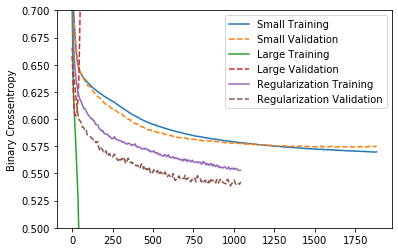

In [18]:
histSmall = pd.DataFrame(size_histories["small"].history)
histSmall['epoch'] = size_histories["small"].epoch

histLarge = pd.DataFrame(size_histories["large"].history)
histLarge['epoch'] = size_histories["large"].epoch

histReg = pd.DataFrame(size_histories["regularization"].history)
histReg['epoch'] = size_histories["regularization"].epoch

trainSmoothSmall = gaussian_filter1d(histSmall['binary_crossentropy'], sigma=3)
testSmoothSmall = gaussian_filter1d(histSmall['val_binary_crossentropy'], sigma=3)

trainSmoothLarge = gaussian_filter1d(histLarge['binary_crossentropy'], sigma=3)
testSmoothLarge = gaussian_filter1d(histLarge['val_binary_crossentropy'], sigma=3)

trainSmoothReg = gaussian_filter1d(histReg['binary_crossentropy'], sigma=3)
testSmoothReg = gaussian_filter1d(histReg['val_binary_crossentropy'], sigma=3)

plt.plot(histSmall['epoch'], trainSmoothSmall, '-', histSmall['epoch'], testSmoothSmall, '--')
plt.plot(histLarge['epoch'], trainSmoothLarge, '-', histLarge['epoch'], testSmoothLarge, '--')
plt.plot(histReg['epoch'], trainSmoothReg, '-', histReg['epoch'], testSmoothReg, '--',)
plt.ylim([0.5, 0.7])
plt.ylabel('Binary Crossentropy')
plt.legend(["Small Training", "Small Validation", "Large Training", "Large Validation", "Regularization Training", "Regularization Validation"])

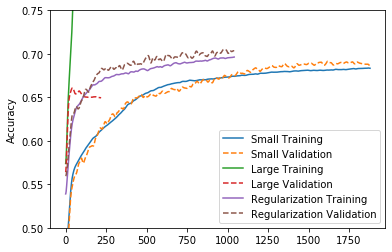

In [19]:
trainSmoothSmall = gaussian_filter1d(histSmall['accuracy'], sigma=6)
testSmoothSmall = gaussian_filter1d(histSmall['val_accuracy'], sigma=6)

trainSmoothLarge = gaussian_filter1d(histLarge['accuracy'], sigma=6)
testSmoothLarge = gaussian_filter1d(histLarge['val_accuracy'], sigma=6)

trainSmoothReg = gaussian_filter1d(histReg['accuracy'], sigma=6)
testSmoothReg = gaussian_filter1d(histReg['val_accuracy'], sigma=6)

plt.plot(histSmall['epoch'], trainSmoothSmall, '-', histSmall['epoch'], testSmoothSmall, '--')
plt.plot(histLarge['epoch'], trainSmoothLarge, '-', histLarge['epoch'], testSmoothLarge, '--')
plt.plot(histReg['epoch'], trainSmoothReg, '-', histReg['epoch'], testSmoothReg, '--',)

plt.ylim([0.5, 0.75])
plt.ylabel('Accuracy')
plt.legend(["Small Training", "Small Validation", "Large Training", "Large Validation","Regularization Training", "Regularization Validation",])